In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
import time

from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../ESC-50/audio/'

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


In [10]:
df = ps.preprocess_fold(dataset,
                        kind='quantized',
                        blocksize=blocksize,
                        overlap=overlap,
                        n_mels=128,
                        power_melgram=2.0,
                        decibel_gram=True,
                        feature_bag=False,
                        folds=3
                       )

In [11]:
df.head()

label,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,target,fold
0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,36,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,2
4,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,19,3


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [12]:
X_train = df[df.fold > 1].drop(['fold', 'target'], axis=1)
X_test = df[df.fold == 1].drop(['fold', 'target'], axis=1)
y_train = df[df.fold > 1]['target']
y_test = df[df.fold == 1]['target']

In [13]:
X_train.shape

(1333, 2048)

In [14]:
y_train.shape

(1333,)

# Deep Net
Separate into classes

In [15]:
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
                      decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
                      max_iter=1000, probability=True, random_state=42, shrinking=True,
                      tol=0.001, verbose=False), n_jobs=10)

clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
  max_iter=1000, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=10)

0.3778110944527736
Confusion matrix, without normalization
[[3 1 0 ... 0 0 0]
 [3 8 1 ... 0 1 0]
 [0 0 6 ... 0 0 1]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 1 ... 0 7 0]
 [0 0 0 ... 0 0 8]]


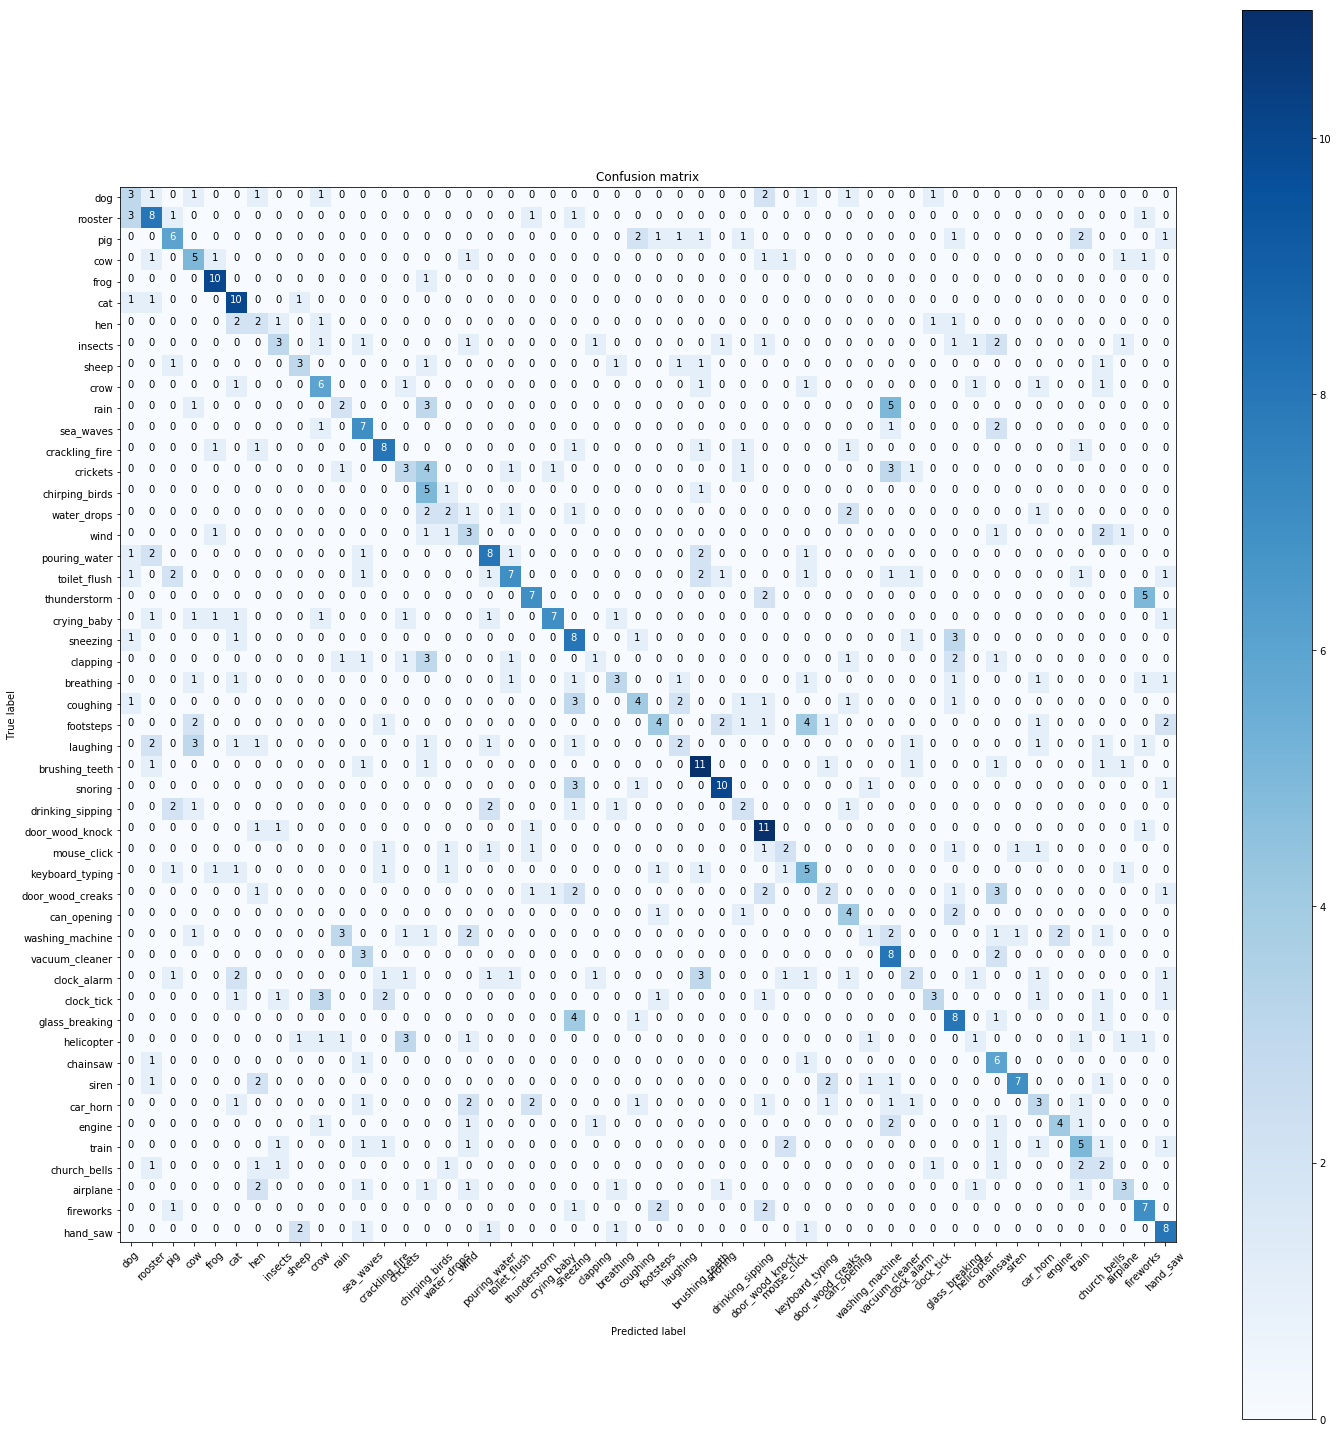

In [16]:
pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, pred))
cm = metrics.confusion_matrix(y_test, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [17]:
y_test = y_test.reset_index(drop=True)

In [18]:
X_test = X_test.reset_index(drop=True)

In [19]:
%%time

predictions = []
full_targets = []
start_time = time.time()
pred_probs = []
time_per_file = []

for data_iloc in range(0,len(y_test)):
    s_time = time.time()
    x_file = X_test[X_test.index == data_iloc]
    
    y_file = y_test[data_iloc]
    
    pred = clf.predict(x_file)
    predictions.append(pred)
    
    full_targets.append(y_file)
    time_per_file.append(time.time() - s_time)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tAverage File Time: " + str(np.average(time_per_file)))
print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 2.7046942710876465
	File Time: 2.2406227588653564
	File Time: 2.074582099914551
	File Time: 2.3544704914093018
	File Time: 2.16546630859375
	File Time: 2.1852364540100098
	File Time: 2.240995407104492
	File Time: 2.2762820720672607
	File Time: 2.405709743499756
	File Time: 2.2841219902038574
	File Time: 2.317521333694458
	File Time: 2.2677853107452393
	File Time: 2.2751305103302
	File Time: 2.282930612564087
	File Time: 2.3433921337127686
	File Time: 2.2494590282440186
	File Time: 2.314812660217285
	File Time: 2.2613561153411865
	File Time: 2.3983705043792725
	File Time: 2.269104242324829
	File Time: 2.035757064819336
	File Time: 2.3370859622955322
	File Time: 2.2763559818267822
	File Time: 2.384172201156616
	File Time: 2.4436912536621094
	File Time: 2.465726375579834
	File Time: 2.3313050270080566
	File Time: 2.432164192199707
	File Time: 2.2510361671447754
	File Time: 2.1986703872680664
	File Time: 2.224055767059326
	File Time: 2.0879311561584473
	File Time: 2.52063488960

	File Time: 2.013583183288574
	File Time: 2.036588191986084
	File Time: 2.0787265300750732
	File Time: 1.9329206943511963
	File Time: 1.9990766048431396
	File Time: 2.0965468883514404
	File Time: 2.139334201812744
	File Time: 1.9214746952056885
	File Time: 1.8716034889221191
	File Time: 2.082059144973755
	File Time: 1.9722955226898193
	File Time: 2.034414529800415
	File Time: 1.9941320419311523
	File Time: 2.061776876449585
	File Time: 1.9777717590332031
	File Time: 2.7119596004486084
	File Time: 2.3358287811279297
	File Time: 2.371181011199951
	File Time: 2.245422124862671
	File Time: 2.3330068588256836
	File Time: 2.326207399368286
	File Time: 2.1013948917388916
	File Time: 2.3195128440856934
	File Time: 2.198888063430786
	File Time: 2.299912452697754
	File Time: 2.301213026046753
	File Time: 2.3230674266815186
	File Time: 2.3660638332366943
	File Time: 2.2608578205108643
	File Time: 2.2329800128936768
	File Time: 2.2817704677581787
	File Time: 2.2355995178222656
	File Time: 2.090786

	File Time: 1.9418911933898926
	File Time: 1.9355030059814453
	File Time: 1.933631181716919
	File Time: 2.0730416774749756
	File Time: 2.1979339122772217
	File Time: 1.9674756526947021
	File Time: 1.799309492111206
	File Time: 1.7814927101135254
	File Time: 1.944500207901001
	File Time: 1.987518548965454
	File Time: 1.843531608581543
	File Time: 2.040323495864868
	File Time: 2.0990824699401855
	File Time: 2.0058624744415283
	File Time: 1.9923148155212402
	File Time: 2.1125967502593994
	File Time: 1.8775835037231445
	File Time: 2.042243480682373
	File Time: 1.9864089488983154
	File Time: 2.074289560317993
	File Time: 2.1818315982818604
	File Time: 2.027986526489258
	File Time: 1.8294389247894287
	File Time: 1.9597129821777344
	File Time: 1.9180517196655273
	File Time: 1.9884285926818848
	File Time: 2.102762222290039
	File Time: 1.9693543910980225
	File Time: 2.079756259918213
	File Time: 2.121706485748291
	File Time: 2.0000267028808594
	File Time: 2.0040955543518066
	File Time: 1.897911

0.3778110944527736
0.3761495477558542
Confusion matrix, without normalization
[[3 1 0 ... 0 0 0]
 [3 8 1 ... 0 1 0]
 [0 0 6 ... 0 0 1]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 1 ... 0 7 0]
 [0 0 0 ... 0 0 8]]


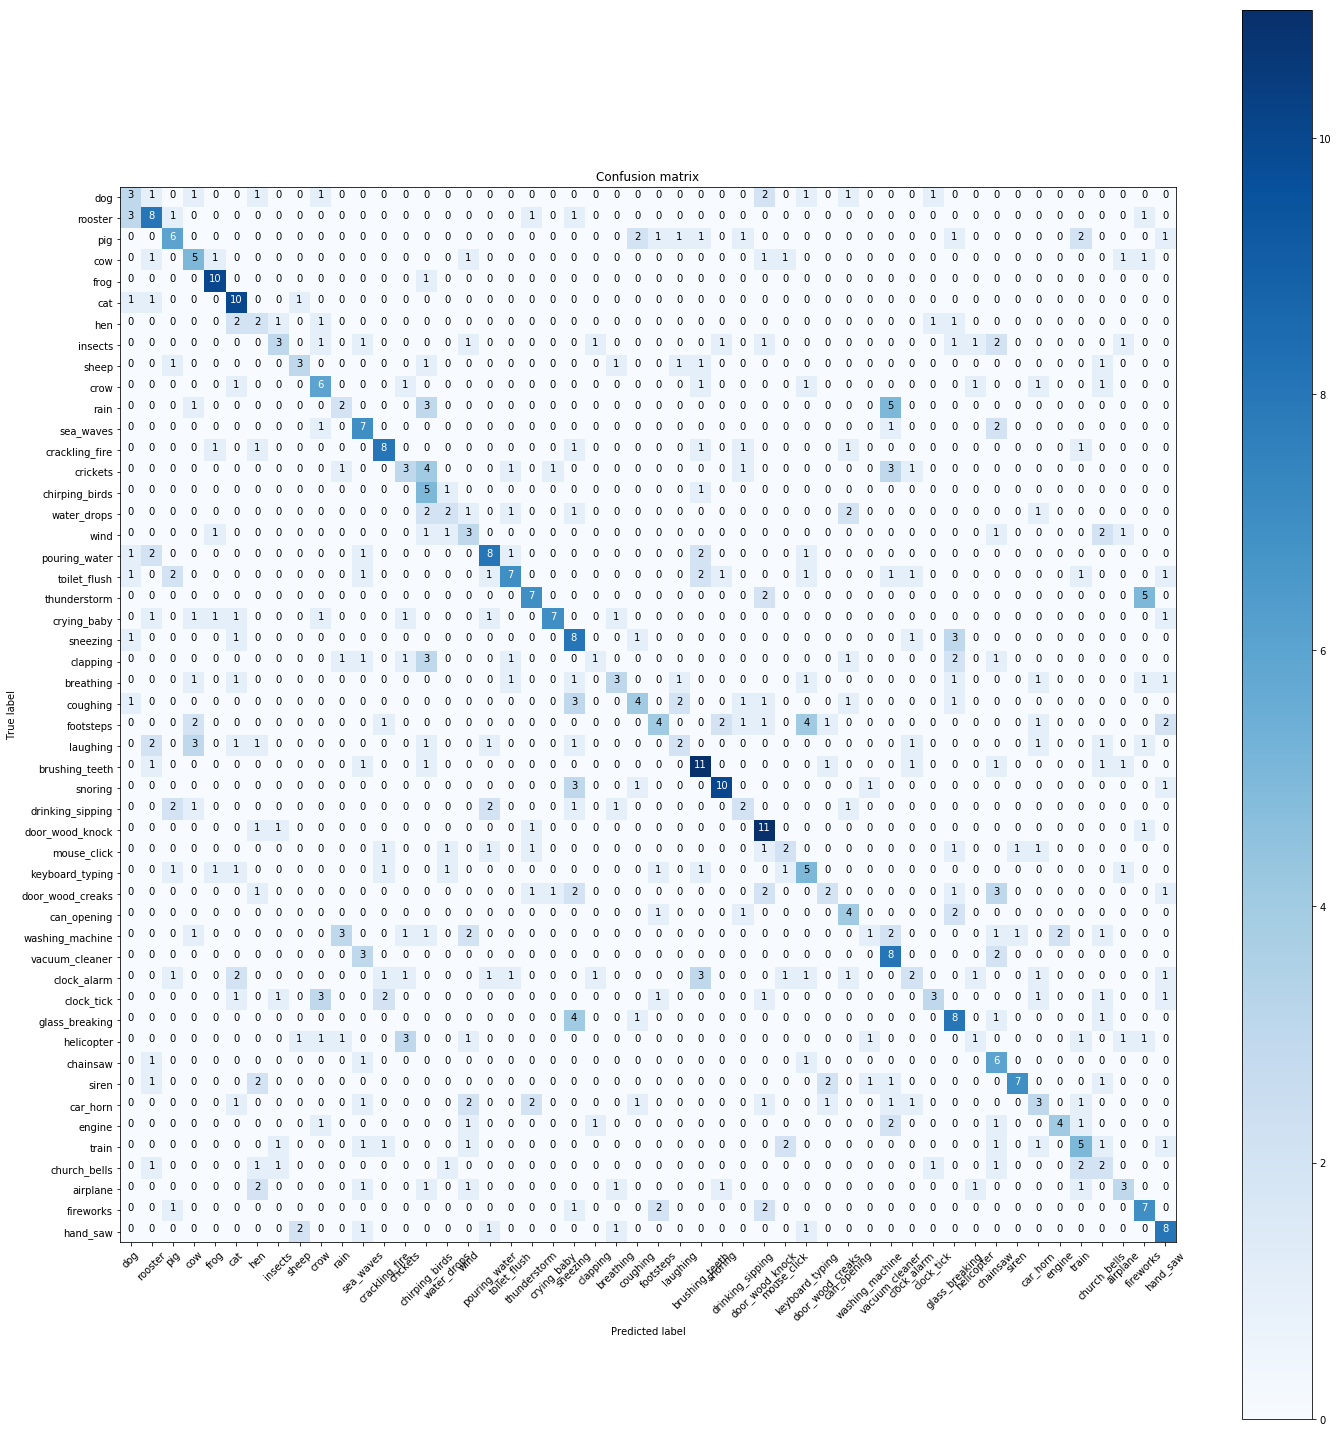

In [20]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [21]:
%%time
from sklearn.model_selection import cross_validate

clf = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('feat_sel', SelectKBest(k=80, score_func=chi2)),
#     ('feat_red', PCA(n_components=50)),
    ('classify', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
                      decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
                      max_iter=1000, probability=True, random_state=42, shrinking=True,
                      tol=0.001, verbose=False)
    )
])

scores = cross_validate(clf, X_train, y_train, cv=3, scoring=['accuracy', 'precision_macro', 'recall_macro'])

CPU times: user 1min 5s, sys: 160 ms, total: 1min 5s
Wall time: 1min 5s


In [22]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('classify', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
  max_iter=1000, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])

In [23]:
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,train_accuracy,train_precision_macro,train_recall_macro
0,14.331023,2.511494,0.323913,0.400712,0.324760,0.947308,0.952732,0.945895
1,14.625795,2.462950,0.277652,0.309429,0.276866,0.956180,0.962457,0.955545
2,14.876288,2.422756,0.283721,0.322506,0.284527,0.935770,0.948266,0.936582


In [24]:
def heuristic(score_array):
    mu_t = np.mean(score_array)
    std_t = np.std(score_array)
    for i in range(0, len(score_array)):
        score_array[i] = (score_array[i] - mu_t)/std_t
    return score_array

In [40]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []
    test = df[df.fold == 1]

    for data_iloc in range(0,len(X_test)):
        x_file = X_test[X_test.index == data_iloc]
    
        y_file = y_test[data_iloc]
        
        y_file = dataset.iloc[data_iloc].h_target
        yy_file = dataset.iloc[data_iloc].target

        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file),
            'decision_funct': heuristic(clf.decision_function(x_file)[0])[l_l],
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['decision_funct'], ascending=False).reset_index(drop=True)
    
    return predictions

In [41]:
%%time
preds = query_dataset('dog')

CPU times: user 6min 17s, sys: 1.1 s, total: 6min 18s
Wall time: 6min 17s


In [42]:
preds.head()

,decision_funct,ds_id,file,prediction,prob
0,1.792660,496,2-118072-A-0.wav,[0],0.668578
1,1.776742,366,1-81883-A-21.wav,[0],0.405428
2,1.766134,484,2-117271-A-0.wav,[0],0.114189
3,1.758329,440,2-106487-A-44.wav,[0],0.267714
4,1.754067,96,1-202111-A-3.wav,[0],0.255567


In [43]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [44]:
# Checking index
check_accuracy(preds, 'dog', 10)

dog
['sneezing', 'engine', 'cow', 'clock_tick', 'crickets', 'washing_machine', 'crackling_fire', 'pig']



0.2

In [ ]:
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 6min 16s, sys: 1.26 s, total: 6min 17s
Wall time: 6min 17s
dog
['sneezing', 'engine', 'cow', 'clock_tick', 'crickets', 'washing_machine', 'crackling_fire', 'pig']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.63 ms
dog
0.2

CPU times: user 6min 14s, sys: 764 ms, total: 6min 15s
Wall time: 6min 14s
rooster
['rain', 'drinking_sipping', 'engine', 'rain', 'crow', 'glass_breaking', 'hand_saw', 'pig', 'chirping_birds', 'hen']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.01 ms
rooster
0.0

CPU times: user 6min 13s, sys: 1.11 s, total: 6min 14s
Wall time: 6min 13s
pig
['thunderstorm', 'helicopter', 'glass_breaking', 'rooster', 'helicopter', 'mouse_click', 'fireworks', 'church_bells', 'can_opening', 'hen']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.94 ms
pig
0.0

CPU times: user 6min 18s, sys: 1.16 s, total: 6min 20s
Wall time: 6min 19s
cow
['breathing', 'fireworks', 'door_wood_knock', 'clapping', 'chirping_birds', 'helicopter', 'wind',